$z = (t-\pi)^4 + \sin(t) + 1$ <br>
$g = dz/dt = 0$ <br>
$\Delta t = -g (dg/dt)^{-1}$ <br>
$g = \textbf{rs} \cdot d\textbf{rs}/dt$ <br>
$\Delta t = - g (\partial g/ \partial t)^{-1}$

In [1]:
import matplotlib.pyplot as plt
plt.style.use('./accretion.mplstyle')
import numpy as np
from astropy import constants as const
from astropy import units as u
from collections import OrderedDict
from itertools import cycle
import matplotlib.image as mpimg
import scipy.ndimage as ndimage
img = mpimg.imread('/storage/home/nxt5197/work/577_exoplanets/eye.png')

In [2]:
def z(t):
    return (t-np.pi)**4 + np.sin(t) + 1

def g(t):
    return 4*(t-np.pi)**3 + np.cos(t)

def dgdt(t):
    return 12*(t-np.pi)**2 - np.sin(t)

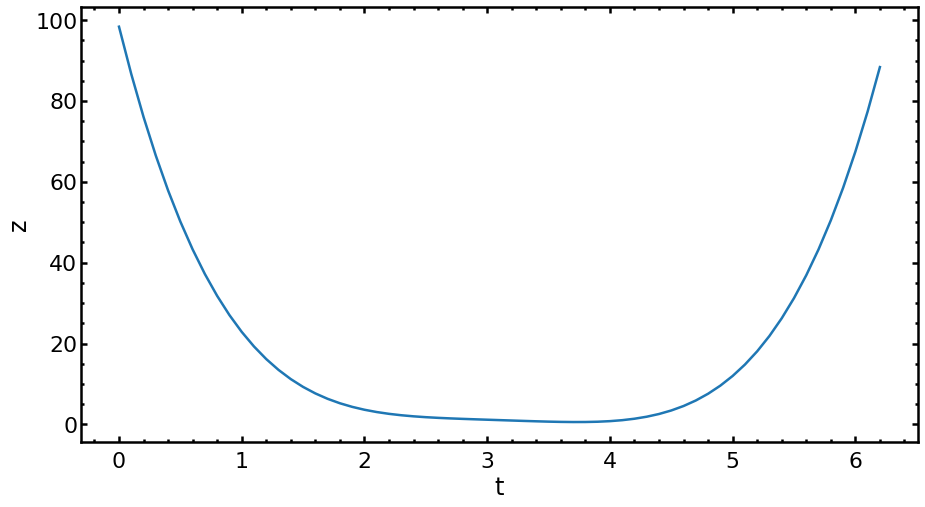

In [3]:
Delta_t=0.1
t = np.arange(0,2*np.pi,Delta_t)
plt.plot(t,z(t))
plt.xlabel('t')
plt.ylabel('z')
plt.show()
# plt.plot(t,g(t))
# plt.show()

In [4]:
i = np.where(z(t)==min(z(t)))[0][0]
best_t = t[i]
print(f'Index of minimum z value: {i}\nt value at that index: {best_t}')
print(f'g value at t = {best_t}:\t{g(best_t)}')

Index of minimum z value: 37
t value at that index: 3.7
g value at t = 3.7:	-0.15161247627339813


In [5]:
count=0
print(f'Starting values:\tbest t: {t[i]}\tg value: {g(t[i])}')
while abs(g(t[i]))>10**-15:
    Delta_t = - g(t[i]) / dgdt(t[i])
    t[i]+=Delta_t
    count+=1
    print(f'{count}\tDelta_t: {t[i]}\tg value: {g(t[i])}')
    if count>10:
        break
best_t=t[i]

Starting values:	best t: 3.7	g value: -0.15161247627339813
1	Delta_t: 3.7354926257223755	g value: 0.009150313214248529
2	Delta_t: 3.7335832090803	g value: 2.7466986329272025e-05
3	Delta_t: 3.733577442881598	g value: 2.4999236014622284e-10
4	Delta_t: 3.7335774428291155	g value: -5.551115123125783e-16


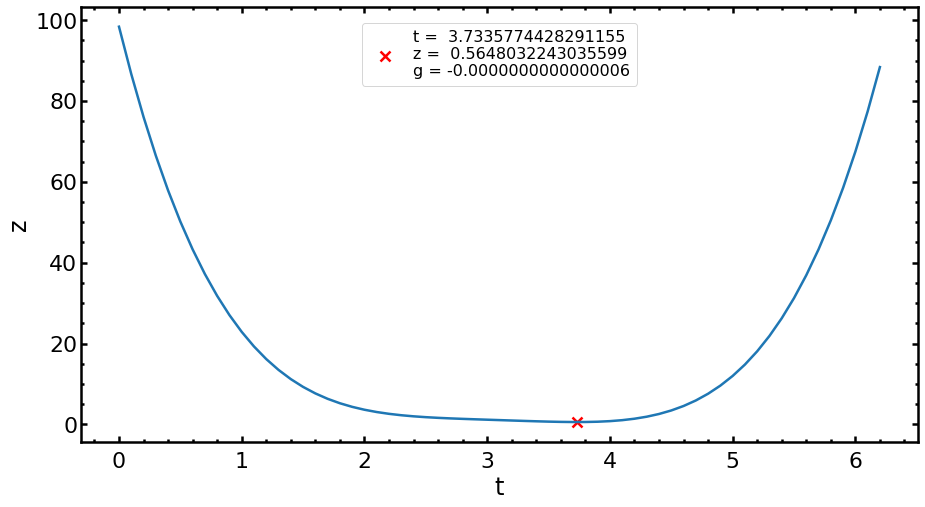

In [6]:
Delta_t=0.1
t = np.arange(0,2*np.pi,Delta_t)
plt.plot(t,z(t))
plt.scatter(best_t,z(best_t),marker='x',color='r',label=f't =  {best_t:.16f}\nz =  {z(best_t):.16f}\ng = {g(best_t):.16f}')
plt.xlabel('t')
plt.ylabel('z')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


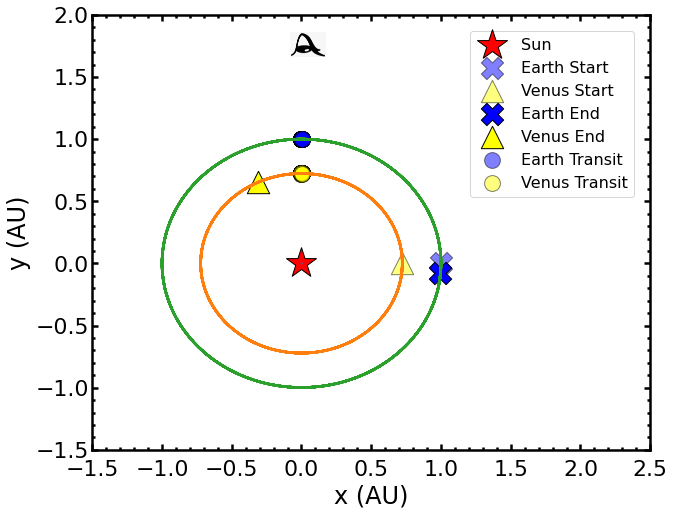

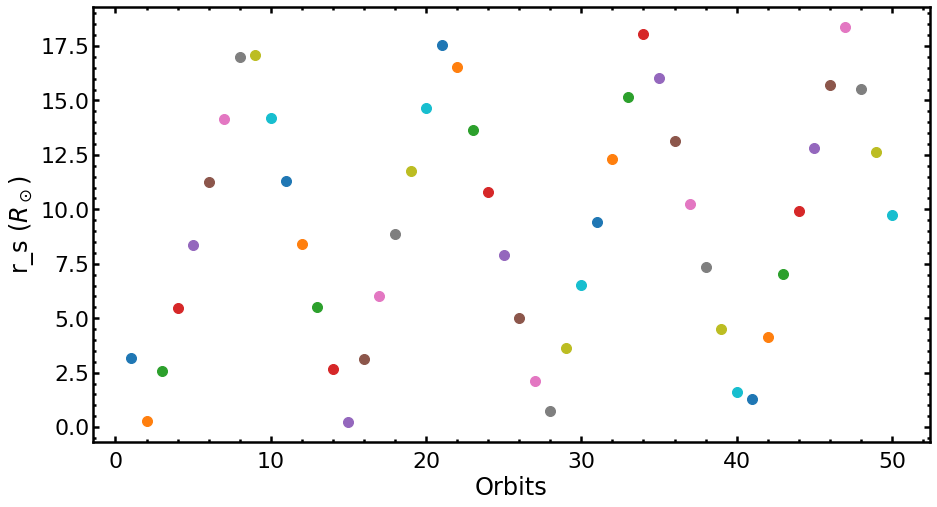

In [15]:
def dvidt(M_j,r_ij,r_i,r_j):
    G = const.G.cgs
    dvdt = -(G * M_j / r_ij**3 * ((r_i[0].value - r_j[0].value,r_i[1].value-r_j[1].value,r_i[2].value-r_j[2].value)*u.cm)).to(u.cm/u.day**2)
    return dvdt

def rmag(r_i,r_j):
    x_i=r_i[0]
    y_i=r_i[1]
    z_i=r_i[2]
    x_j=r_j[0]
    y_j=r_j[1]
    z_j=r_j[2]
    r_ij = np.sqrt((x_i-x_j)**2+(y_i-y_j)**2+(z_i-z_j)**2)
    return r_ij

def r_s_mag(r_i,r_j):
    x_i=r_i[0]
    y_i=r_i[1]
    z_i=r_i[2]
    x_j=r_j[0]
    y_j=r_j[1]
    z_j=r_j[2]
    r_ij = np.sqrt((x_i-x_j)**2+(z_i-z_j)**2)
    return r_ij

def finp(v,dt,x):
    return v*dt+x

def finv(v,dvdt,dt):
    return v+dvdt*dt

linecycler = cycle([(0,()), # solid 
                     (0, (1, 10)), # loosely dotted
                     (0, (1, 5)), # dotted
                     (0, (1, 1)), # densely dotted
                     (0, (5, 10)), # loosely dashed
                     (0, (5, 5)), # dashed
                     (0, (5, 1)), # densely dashed
                     (0, (3, 10, 1, 10)), # loosely dashdotted
                     (0, (3, 5, 1, 5)), # dashdotted
                     (0, (3, 1, 1, 1)), # densely dashdotted
                     (0, (3, 10, 1, 10, 1, 10)), # loosely dashdotdotted
                     (0, (3, 5, 1, 5, 1, 5)), # dashdotdotted
                     (0, (3, 1, 1, 1, 1, 1))]) # densely dashdotdotted

delta_ts = [0.1,0.3,0.6,0.8,1]*u.day
delta_ts = [0.1]*u.day

b = OrderedDict((("Sun",0),("Venus",1),("Earth",2)))

G = const.G.cgs
a_e = const.au.to(u.cm)
a_v = 0.723*const.au.to(u.cm)
a = OrderedDict(((2,a_e),(1,a_v)))
m_e = const.M_earth.to(u.g)
m_v = (4.8673*10**27)*u.g
m_s = const.M_sun.to(u.g)
m = OrderedDict(((2,m_e),(1,m_v),(0,m_s)))

orbits = 50

for n,delta_t in enumerate(delta_ts):
    fig=plt.figure(figsize=(10,8))
    t_range = np.arange(0,orbits*365,delta_t.value)*u.day      # 1 year timescale in steps of delta_t
    # Initialize position and velocity arrays
    r = [[(0,0,0)]*len(t_range) for i in range(len(b))]
    x = [[0]*len(t_range) for i in range(len(b))]
    y = [[0]*len(t_range) for i in range(len(b))]
    z = [[0]*len(t_range) for i in range(len(b))]
    v = [[(0,0,0)]*len(t_range) for i in range(len(b))]

    steps=len(t_range)                                  # The number of steps in the time array
    # Set initial position for Earth and Sun
    r[b["Earth"]][0] = (a[b["Earth"]],0*u.cm,0*u.cm)
    r[b["Venus"]][0] = (a[b["Venus"]],0*u.cm,0*u.cm)
    r[b["Sun"]][0] = ((-a[b["Earth"]]*(m[b["Earth"]]+m[b["Venus"]])/m[b["Sun"]]).to(u.cm),0*u.cm,0*u.cm)
    x[b["Earth"]][0] = r[b["Earth"]][0][0]
    y[b["Earth"]][0] = r[b["Earth"]][0][1]
    z[b["Earth"]][0] = r[b["Earth"]][0][2]
    x[b["Venus"]][0] = r[b["Venus"]][0][0]
    y[b["Venus"]][0] = r[b["Venus"]][0][1]
    z[b["Venus"]][0] = r[b["Venus"]][0][2]
    x[b["Sun"]][0] = r[b["Sun"]][0][0]
    y[b["Sun"]][0] = r[b["Sun"]][0][1]
    z[b["Sun"]][0] = r[b["Sun"]][0][2]
    # Set initial velocities for Earth and Sun
    v[b["Earth"]][0] = (0*u.cm/u.day,(29.78*u.km/u.s).to(u.cm/u.day),0*u.cm/u.day)
    v[b["Venus"]][0] = (0*u.cm/u.day,v[b["Earth"]][0][1]*1.176,0*u.cm/u.day)
    v[b["Sun"]][0] = (0*u.cm/u.day,-np.sqrt(G*(sum([m[i] for i in range(len(b))]))/(a[b["Earth"]]+x[b["Sun"]][0])).to(u.cm/u.day)*m[b["Earth"]]/sum([m[i] for i in range(len(b))]),0*u.cm/u.day)

    for t in range(steps-1): # indexing each timestep as t
        # Get radius magnitudes from x,y coordinates
        for i, body in enumerate(b):
            for j, body in enumerate(b):
                if i==j:
                    continue
                if i==1 and j==2:
                    continue
                if i==2 and j==1:
                    continue
                # Update the radial position arrays: r' = r + v * dt
                r[i][t+1] = (r[i][t][0] + v[i][t][0]*delta_t,r[i][t][1] + v[i][t][1]*delta_t,r[i][t][2] + v[i][t][2]*delta_t)
                r[j][t+1] = (r[j][t][0] + v[j][t][0]*delta_t,r[j][t][1] + v[j][t][1]*delta_t,r[j][t][2] + v[j][t][2]*delta_t)
                # Add the new position to each coordinate array: x_final = v*delta_t + x_initial
                x[i][t+1] = r[i][t+1][0]
                y[i][t+1] = r[i][t+1][1]
                z[i][t+1] = r[i][t+1][2]
                # Update the delta v
                r_ij = rmag(r[i][t+1],r[j][t+1])
                dv_i_dt = dvidt(m[j],r_ij,r[i][t+1],r[j][t+1])
                # Update the velocity arrays: v' = v + dv/dt * dt
                v[i][t+1] = (v[i][t][0] + dv_i_dt[0] * delta_t,v[i][t][1] + dv_i_dt[1] * delta_t,v[i][t][2] + dv_i_dt[2] * delta_t)
    # Plot the coordinates for the Earth and the Sun over time.
    for i, body in enumerate(b):
        x_au = [(xs/a[b["Earth"]]).value for xs in x[i]]
        y_au = [(ys/a[b["Earth"]]).value for ys in y[i]]
        z_au = [(zs/a[b["Earth"]]).value for zs in z[i]]
        line=next(linecycler)
        plt.plot(x_au,y_au,linestyle=line)#,label=f'{list(b.items())[i][0]} {delta_t}')
    plt.ylabel('y (AU)')
    plt.xlabel('x (AU)')
    plt.xlim(-1.5,2.5)
    plt.ylim(-1.5,2)
    plt.scatter(x[b["Sun"]][0]/a_e,y[b["Sun"]][0]/a_e,marker="*",s=1000,color='red', edgecolors='black',label=f'Sun')
    plt.scatter(x[b["Earth"]][0]/a_e,y[b["Earth"]][0]/a_e,marker="X",s=500,color='blue', edgecolors='black',alpha=0.5,label=f'Earth Start')
    plt.scatter(x[b["Venus"]][0]/a_e,y[b["Venus"]][0]/a_e,marker="^",s=500,color='yellow', edgecolors='black',alpha=0.5,label=f'Venus Start')
    plt.scatter(x[b["Earth"]][-1]/a_e,y[b["Earth"]][-1]/a_e,marker="X",s=500,color='blue', edgecolors='black',label=f'Earth End')
    plt.scatter(x[b["Venus"]][-1]/a_e,y[b["Venus"]][-1]/a_e,marker="^",s=500,color='yellow', edgecolors='black',label=f'Venus End')
    SE_xdiff = abs(np.array([i.value for i in x[b["Sun"]]]) - np.array([i.value for i in x[b["Earth"]]]))
    if delta_t.value <= 0.01:
        earth_transits = np.where(SE_xdiff<=(const.R_sun.value+const.R_earth.value))[0]
    else:
        earth_transits=[]
        for o in range(orbits*2):
            orbit_steps=steps/orbits/2
            xdiff = SE_xdiff[int(o*orbit_steps):int(o*orbit_steps+orbit_steps)]
            earth_transits.append(np.where(min(xdiff)==SE_xdiff)[0][0])
    label_added=False
    for i in earth_transits:
        if y[b["Earth"]][i] > 0:
            if not label_added:
                plt.scatter(x[b["Earth"]][i]/a_e,y[b["Earth"]][i]/a_e,marker="o",s=250,color='blue', edgecolors='black',label=f'Earth Transit',alpha=0.5)
                label_added = True
            else:
                plt.scatter(x[b["Earth"]][i]/a_e,y[b["Earth"]][i]/a_e,marker="o",s=250,color='blue', edgecolors='black',alpha=0.5)
    SV_xdiff = abs(np.array([i.value for i in x[b["Sun"]]]) - np.array([i.value for i in x[b["Venus"]]]))
    if delta_t.value <= 0.01:
        venus_transits = np.where(SV_xdiff<=(const.R_sun.value+const.R_earth.value))[0]
    else:
        venus_transits=[]
        for o in range(orbits*2):
            orbit_steps=0.6152*steps/orbits/2
            xdiff = SV_xdiff[int(o*orbit_steps):int(o*orbit_steps+orbit_steps)]
            venus_transits.append(np.where(min(xdiff)==SV_xdiff)[0][0])
    label_added=False
    for i in venus_transits:
        if y[b["Venus"]][i] > 0:
            if not label_added:
                plt.scatter(x[b["Venus"]][i]/a_e,y[b["Venus"]][i]/a_e,marker="o",s=250,color='yellow', edgecolors='black',label=f'Venus Transit',alpha=0.5)
                label_added = True
            else:
                plt.scatter(x[b["Venus"]][i]/a_e,y[b["Venus"]][i]/a_e,marker="o",s=250,color='yellow', edgecolors='black',alpha=0.5)
    plt.legend()
    new_img = ndimage.rotate(img, -90, reshape=True)
    newax = fig.add_axes([0.4, 0.8, 0.05, 0.05], anchor='NE', zorder=1)
    newax.imshow(new_img)
    newax.axis('off')
    plt.show()
    for t,i in enumerate(earth_transits):
        if y[b["Earth"]][i] > 0:
            r_s = r_s_mag(r[b["Sun"]][i],r[b["Earth"]][i])/const.R_sun.value
            time = t/2+1
            plt.scatter(time,r_s)
    plt.ylabel(rf'r_s ($R_\odot$)')
    plt.xlabel(f'Orbits')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


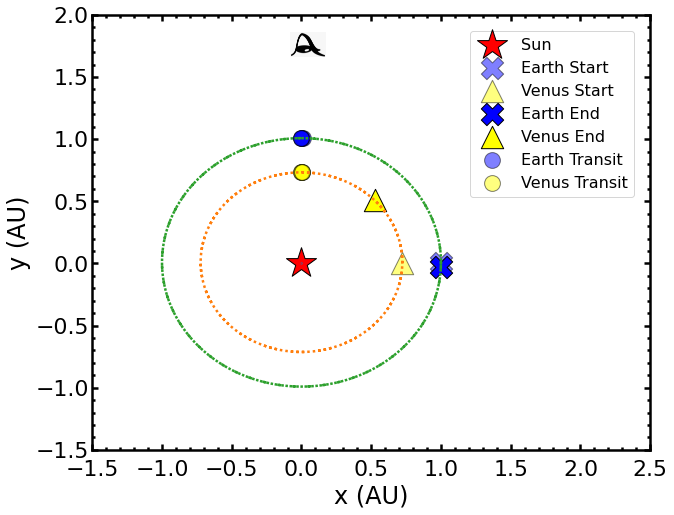

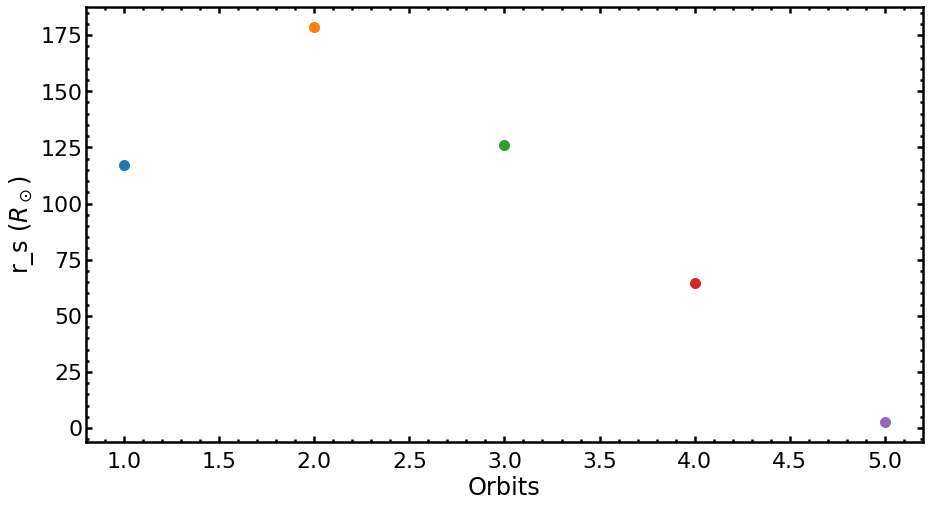

In [16]:
def dvidt(M_j,r_ij,r_i,r_j):
    G = const.G.cgs
    dvdt = -(G * M_j / r_ij**3 * ((r_i[0].value - r_j[0].value,r_i[1].value-r_j[1].value,r_i[2].value-r_j[2].value)*u.cm)).to(u.cm/u.day**2)
    return dvdt

def rmag(r_i,r_j):
    x_i=r_i[0]
    y_i=r_i[1]
    z_i=r_i[2]
    x_j=r_j[0]
    y_j=r_j[1]
    z_j=r_j[2]
    r_ij = np.sqrt((x_i-x_j)**2+(y_i-y_j)**2+(z_i-z_j)**2)
    return r_ij

def r_s_mag(r_i,r_j):
    x_i=r_i[0]
    y_i=r_i[1]
    z_i=r_i[2]
    x_j=r_j[0]
    y_j=r_j[1]
    z_j=r_j[2]
    r_ij = np.sqrt((x_i-x_j)**2+(z_i-z_j)**2)
    return r_ij

def finp(v,dt,x):
    return v*dt+x

def finv(v,dvdt,dt):
    return v+dvdt*dt

linecycler = cycle([(0,()), # solid 
                     (0, (1, 10)), # loosely dotted
                     (0, (1, 5)), # dotted
                     (0, (1, 1)), # densely dotted
                     (0, (5, 10)), # loosely dashed
                     (0, (5, 5)), # dashed
                     (0, (5, 1)), # densely dashed
                     (0, (3, 10, 1, 10)), # loosely dashdotted
                     (0, (3, 5, 1, 5)), # dashdotted
                     (0, (3, 1, 1, 1)), # densely dashdotted
                     (0, (3, 10, 1, 10, 1, 10)), # loosely dashdotdotted
                     (0, (3, 5, 1, 5, 1, 5)), # dashdotdotted
                     (0, (3, 1, 1, 1, 1, 1))]) # densely dashdotdotted

delta_ts = [0.1,0.3,0.6,0.8,1]*u.day
delta_ts = [1]*u.day

b = OrderedDict((("Sun",0),("Venus",1),("Earth",2)))

G = const.G.cgs
a_e = const.au.to(u.cm)
a_v = 0.723*const.au.to(u.cm)
a = OrderedDict(((2,a_e),(1,a_v)))
m_e = const.M_earth.to(u.g)
m_v = (4.8673*10**27)*u.g
m_s = const.M_sun.to(u.g)
m = OrderedDict(((2,m_e),(1,m_v),(0,m_s)))

orbits = 5

for n,delta_t in enumerate(delta_ts):
    fig=plt.figure(figsize=(10,8))
    t_range = np.arange(0,orbits*365,delta_t.value)*u.day      # 1 year timescale in steps of delta_t
    # Initialize position and velocity arrays
    r = [[(0,0,0)]*len(t_range) for i in range(len(b))]
    x = [[0]*len(t_range) for i in range(len(b))]
    y = [[0]*len(t_range) for i in range(len(b))]
    z = [[0]*len(t_range) for i in range(len(b))]
    v = [[(0,0,0)]*len(t_range) for i in range(len(b))]

    steps=len(t_range)                                  # The number of steps in the time array
    # Set initial position for Earth and Sun
    r[b["Earth"]][0] = (a[b["Earth"]],0*u.cm,0*u.cm)
    r[b["Venus"]][0] = (a[b["Venus"]],0*u.cm,0*u.cm)
    r[b["Sun"]][0] = ((-a[b["Earth"]]*(m[b["Earth"]]+m[b["Venus"]])/m[b["Sun"]]).to(u.cm),0*u.cm,0*u.cm)
    x[b["Earth"]][0] = r[b["Earth"]][0][0]
    y[b["Earth"]][0] = r[b["Earth"]][0][1]
    z[b["Earth"]][0] = r[b["Earth"]][0][2]
    x[b["Venus"]][0] = r[b["Venus"]][0][0]
    y[b["Venus"]][0] = r[b["Venus"]][0][1]
    z[b["Venus"]][0] = r[b["Venus"]][0][2]
    x[b["Sun"]][0] = r[b["Sun"]][0][0]
    y[b["Sun"]][0] = r[b["Sun"]][0][1]
    z[b["Sun"]][0] = r[b["Sun"]][0][2]
    # Set initial velocities for Earth and Sun
    v[b["Earth"]][0] = (0*u.cm/u.day,(29.78*u.km/u.s).to(u.cm/u.day),0*u.cm/u.day)
    v[b["Venus"]][0] = (0*u.cm/u.day,v[b["Earth"]][0][1]*1.176,0*u.cm/u.day)
    v[b["Sun"]][0] = (0*u.cm/u.day,-np.sqrt(G*(sum([m[i] for i in range(len(b))]))/(a[b["Earth"]]+x[b["Sun"]][0])).to(u.cm/u.day)*m[b["Earth"]]/sum([m[i] for i in range(len(b))]),0*u.cm/u.day)

    for t in range(steps-1): # indexing each timestep as t
        # Get radius magnitudes from x,y coordinates
        for i, body in enumerate(b):
            for j, body in enumerate(b):
                if i==j:
                    continue
                if i==1 and j==2:
                    continue
                if i==2 and j==1:
                    continue
                # Update the radial position arrays: r' = r + v * dt
                r[i][t+1] = (r[i][t][0] + v[i][t][0]*delta_t,r[i][t][1] + v[i][t][1]*delta_t,r[i][t][2] + v[i][t][2]*delta_t)
                r[j][t+1] = (r[j][t][0] + v[j][t][0]*delta_t,r[j][t][1] + v[j][t][1]*delta_t,r[j][t][2] + v[j][t][2]*delta_t)
                # Add the new position to each coordinate array: x_final = v*delta_t + x_initial
                x[i][t+1] = r[i][t+1][0]
                y[i][t+1] = r[i][t+1][1]
                z[i][t+1] = r[i][t+1][2]
                # Update the delta v
                r_ij = rmag(r[i][t+1],r[j][t+1])
                dv_i_dt = dvidt(m[j],r_ij,r[i][t+1],r[j][t+1])
                # Update the velocity arrays: v' = v + dv/dt * dt
                v[i][t+1] = (v[i][t][0] + dv_i_dt[0] * delta_t,v[i][t][1] + dv_i_dt[1] * delta_t,v[i][t][2] + dv_i_dt[2] * delta_t)
    # Plot the coordinates for the Earth and the Sun over time.
    for i, body in enumerate(b):
        x_au = [(xs/a[b["Earth"]]).value for xs in x[i]]
        y_au = [(ys/a[b["Earth"]]).value for ys in y[i]]
        z_au = [(zs/a[b["Earth"]]).value for zs in z[i]]
        line=next(linecycler)
        plt.plot(x_au,y_au,linestyle=line)#,label=f'{list(b.items())[i][0]} {delta_t}')
    plt.ylabel('y (AU)')
    plt.xlabel('x (AU)')
    plt.xlim(-1.5,2.5)
    plt.ylim(-1.5,2)
    plt.scatter(x[b["Sun"]][0]/a_e,y[b["Sun"]][0]/a_e,marker="*",s=1000,color='red', edgecolors='black',label=f'Sun')
    plt.scatter(x[b["Earth"]][0]/a_e,y[b["Earth"]][0]/a_e,marker="X",s=500,color='blue', edgecolors='black',alpha=0.5,label=f'Earth Start')
    plt.scatter(x[b["Venus"]][0]/a_e,y[b["Venus"]][0]/a_e,marker="^",s=500,color='yellow', edgecolors='black',alpha=0.5,label=f'Venus Start')
    plt.scatter(x[b["Earth"]][-1]/a_e,y[b["Earth"]][-1]/a_e,marker="X",s=500,color='blue', edgecolors='black',label=f'Earth End')
    plt.scatter(x[b["Venus"]][-1]/a_e,y[b["Venus"]][-1]/a_e,marker="^",s=500,color='yellow', edgecolors='black',label=f'Venus End')
    SE_xdiff = abs(np.array([i.value for i in x[b["Sun"]]]) - np.array([i.value for i in x[b["Earth"]]]))
    if delta_t.value <= 0.01:
        earth_transits = np.where(SE_xdiff<=(const.R_sun.value+const.R_earth.value))[0]
    else:
        earth_transits=[]
        for o in range(orbits*2):
            orbit_steps=steps/orbits/2
            xdiff = SE_xdiff[int(o*orbit_steps):int(o*orbit_steps+orbit_steps)]
            earth_transits.append(np.where(min(xdiff)==SE_xdiff)[0][0])
    label_added=False
    for i in earth_transits:
        if y[b["Earth"]][i] > 0:
            if not label_added:
                plt.scatter(x[b["Earth"]][i]/a_e,y[b["Earth"]][i]/a_e,marker="o",s=250,color='blue', edgecolors='black',label=f'Earth Transit',alpha=0.5)
                label_added = True
            else:
                plt.scatter(x[b["Earth"]][i]/a_e,y[b["Earth"]][i]/a_e,marker="o",s=250,color='blue', edgecolors='black',alpha=0.5)
    SV_xdiff = abs(np.array([i.value for i in x[b["Sun"]]]) - np.array([i.value for i in x[b["Venus"]]]))
    if delta_t.value <= 0.01:
        venus_transits = np.where(SV_xdiff<=(const.R_sun.value+const.R_earth.value))[0]
    else:
        venus_transits=[]
        for o in range(orbits*2):
            orbit_steps=0.6152*steps/orbits/2
            xdiff = SV_xdiff[int(o*orbit_steps):int(o*orbit_steps+orbit_steps)]
            venus_transits.append(np.where(min(xdiff)==SV_xdiff)[0][0])
    label_added=False
    for i in venus_transits:
        if y[b["Venus"]][i] > 0:
            if not label_added:
                plt.scatter(x[b["Venus"]][i]/a_e,y[b["Venus"]][i]/a_e,marker="o",s=250,color='yellow', edgecolors='black',label=f'Venus Transit',alpha=0.5)
                label_added = True
            else:
                plt.scatter(x[b["Venus"]][i]/a_e,y[b["Venus"]][i]/a_e,marker="o",s=250,color='yellow', edgecolors='black',alpha=0.5)
    plt.legend()
    new_img = ndimage.rotate(img, -90, reshape=True)
    newax = fig.add_axes([0.4, 0.8, 0.05, 0.05], anchor='NE', zorder=1)
    newax.imshow(new_img)
    newax.axis('off')
    plt.show()
    for t,i in enumerate(earth_transits):
        if y[b["Earth"]][i] > 0:
            r_s = r_s_mag(r[b["Sun"]][i],r[b["Earth"]][i])/const.R_sun.value
            time = t/2+1
            plt.scatter(time,r_s)
    plt.ylabel(rf'r_s ($R_\odot$)')
    plt.xlabel(f'Orbits')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


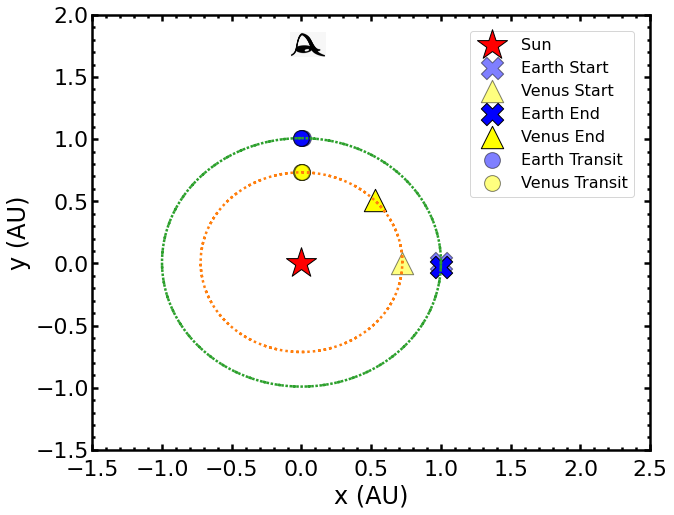

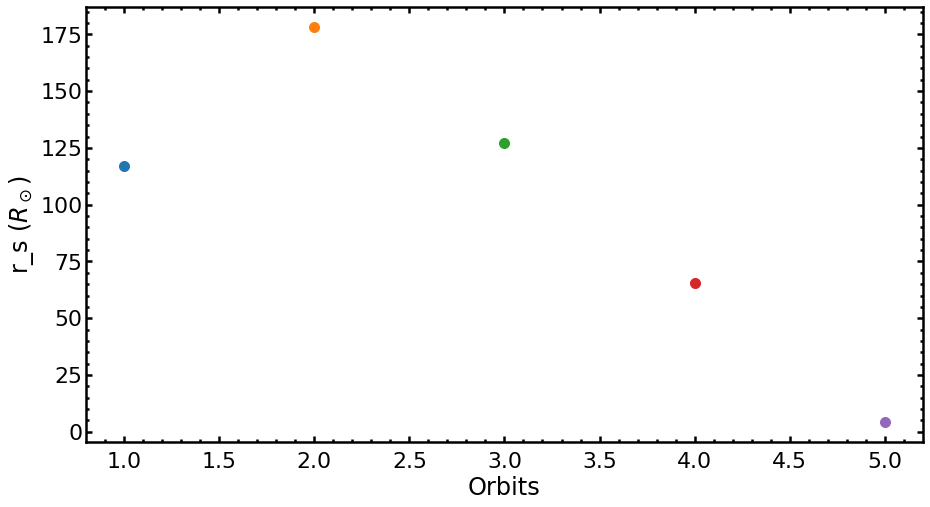

In [17]:
def dvidt(M_j,r_ij,r_i,r_j):
    G = const.G.cgs
    dvdt = -(G * M_j / r_ij**3 * ((r_i[0].value - r_j[0].value,r_i[1].value-r_j[1].value,r_i[2].value-r_j[2].value)*u.cm)).to(u.cm/u.day**2)
    return dvdt

def rmag(r_i,r_j):
    x_i=r_i[0]
    y_i=r_i[1]
    z_i=r_i[2]
    x_j=r_j[0]
    y_j=r_j[1]
    z_j=r_j[2]
    r_ij = np.sqrt((x_i-x_j)**2+(y_i-y_j)**2+(z_i-z_j)**2)
    return r_ij

def r_s_mag(r_i,r_j):
    x_i=r_i[0]
    y_i=r_i[1]
    z_i=r_i[2]
    x_j=r_j[0]
    y_j=r_j[1]
    z_j=r_j[2]
    r_ij = np.sqrt((x_i-x_j)**2+(z_i-z_j)**2)
    return r_ij

def finp(v,dt,x):
    return v*dt+x

def finv(v,dvdt,dt):
    return v+dvdt*dt

linecycler = cycle([(0,()), # solid 
                     (0, (1, 10)), # loosely dotted
                     (0, (1, 5)), # dotted
                     (0, (1, 1)), # densely dotted
                     (0, (5, 10)), # loosely dashed
                     (0, (5, 5)), # dashed
                     (0, (5, 1)), # densely dashed
                     (0, (3, 10, 1, 10)), # loosely dashdotted
                     (0, (3, 5, 1, 5)), # dashdotted
                     (0, (3, 1, 1, 1)), # densely dashdotted
                     (0, (3, 10, 1, 10, 1, 10)), # loosely dashdotdotted
                     (0, (3, 5, 1, 5, 1, 5)), # dashdotdotted
                     (0, (3, 1, 1, 1, 1, 1))]) # densely dashdotdotted

delta_ts = [0.1,0.3,0.6,0.8,1]*u.day
delta_ts = [1]*u.day

b = OrderedDict((("Sun",0),("Venus",1),("Earth",2)))

G = const.G.cgs
a_e = const.au.to(u.cm)
a_v = 0.723*const.au.to(u.cm)
a = OrderedDict(((2,a_e),(1,a_v)))
m_e = const.M_earth.to(u.g)
m_v = (4.8673*10**27)*u.g
m_s = const.M_sun.to(u.g)
m = OrderedDict(((2,m_e),(1,m_v),(0,m_s)))

orbits = 5

for n,delta_t in enumerate(delta_ts):
    fig=plt.figure(figsize=(10,8))
    t_range = np.arange(0,orbits*365,delta_t.value)*u.day      # 1 year timescale in steps of delta_t
    # Initialize position and velocity arrays
    r = [[(0,0,0)]*len(t_range) for i in range(len(b))]
    x = [[0]*len(t_range) for i in range(len(b))]
    y = [[0]*len(t_range) for i in range(len(b))]
    z = [[0]*len(t_range) for i in range(len(b))]
    v = [[(0,0,0)]*len(t_range)*u.cm/u.day for i in range(len(b))]

    steps=len(t_range)                                  # The number of steps in the time array
    # Set initial position for Earth and Sun
    r[b["Earth"]][0] = (a[b["Earth"]],0*u.cm,0*u.cm)
    r[b["Venus"]][0] = (a[b["Venus"]],0*u.cm,0*u.cm)
    r[b["Sun"]][0] = ((-a[b["Earth"]]*(m[b["Earth"]]+m[b["Venus"]])/m[b["Sun"]]).to(u.cm),0*u.cm,0*u.cm)
    x[b["Earth"]][0] = r[b["Earth"]][0][0]
    y[b["Earth"]][0] = r[b["Earth"]][0][1]
    z[b["Earth"]][0] = r[b["Earth"]][0][2]
    x[b["Venus"]][0] = r[b["Venus"]][0][0]
    y[b["Venus"]][0] = r[b["Venus"]][0][1]
    z[b["Venus"]][0] = r[b["Venus"]][0][2]
    x[b["Sun"]][0] = r[b["Sun"]][0][0]
    y[b["Sun"]][0] = r[b["Sun"]][0][1]
    z[b["Sun"]][0] = r[b["Sun"]][0][2]
    # Set initial velocities for Earth and Sun
    v[b["Earth"]][0] = (0*u.cm/u.day,(29.78*u.km/u.s).to(u.cm/u.day),0*u.cm/u.day)
    v[b["Venus"]][0] = (0*u.cm/u.day,v[b["Earth"]][0][1]*1.176,0*u.cm/u.day)
    v[b["Sun"]][0] = (0*u.cm/u.day,-np.sqrt(G*(sum([m[i] for i in range(len(b))]))/(a[b["Earth"]]+x[b["Sun"]][0])).to(u.cm/u.day)*m[b["Earth"]]/sum([m[i] for i in range(len(b))]),0*u.cm/u.day)

    for t in range(steps-1): # indexing each timestep as t
        # Get radius magnitudes from x,y coordinates
        for i, body in enumerate(b):
            for j, body in enumerate(b):
                if i==j:
                    continue
                # if i==1 and j==2:
                #     continue
                # if i==2 and j==1:
                #     continue
                # Update the radial position arrays: r' = r + v * dt
                if r[i][t+1] == (0,0,0):
                    r[i][t+1] = (r[i][t][0] + v[i][t][0]*delta_t,r[i][t][1] + v[i][t][1]*delta_t,r[i][t][2] + v[i][t][2]*delta_t)
                # r[j][t+1] = (r[j][t][0] + v[j][t][0]*delta_t,r[j][t][1] + v[j][t][1]*delta_t,r[j][t][2] + v[j][t][2]*delta_t)
                # Add the new position to each coordinate array: x_final = v*delta_t + x_initial
                x[i][t+1] = r[i][t+1][0]
                y[i][t+1] = r[i][t+1][1]
                z[i][t+1] = r[i][t+1][2]
                # Update the delta v
                if r[j][t+1] != (0,0,0) and r[i][t+1] != (0,0,0):
                    r_ij = rmag(r[i][t+1],r[j][t+1])
                    dv_i_dt = dvidt(m[j],r_ij,r[i][t+1],r[j][t+1])
                    # Update the velocity arrays: v' = v + dv/dt * dt
                    if tuple(v[i][t+1]) == (0,0,0):
                        v[i][t+1] = (v[i][t][0] + dv_i_dt[0] * delta_t,v[i][t][1] + dv_i_dt[1] * delta_t,v[i][t][2] + dv_i_dt[2] * delta_t)
    # Plot the coordinates for the Earth and the Sun over time.
    for i, body in enumerate(b):
        x_au = [(xs/a[b["Earth"]]).value for xs in x[i]]
        y_au = [(ys/a[b["Earth"]]).value for ys in y[i]]
        z_au = [(zs/a[b["Earth"]]).value for zs in z[i]]
        line=next(linecycler)
        plt.plot(x_au,y_au,linestyle=line)#,label=f'{list(b.items())[i][0]} {delta_t}')
    plt.ylabel('y (AU)')
    plt.xlabel('x (AU)')
    plt.xlim(-1.5,2.5)
    plt.ylim(-1.5,2)
    plt.scatter(x[b["Sun"]][0]/a_e,y[b["Sun"]][0]/a_e,marker="*",s=1000,color='red', edgecolors='black',label=f'Sun')
    plt.scatter(x[b["Earth"]][0]/a_e,y[b["Earth"]][0]/a_e,marker="X",s=500,color='blue', edgecolors='black',alpha=0.5,label=f'Earth Start')
    plt.scatter(x[b["Venus"]][0]/a_e,y[b["Venus"]][0]/a_e,marker="^",s=500,color='yellow', edgecolors='black',alpha=0.5,label=f'Venus Start')
    plt.scatter(x[b["Earth"]][-1]/a_e,y[b["Earth"]][-1]/a_e,marker="X",s=500,color='blue', edgecolors='black',label=f'Earth End')
    plt.scatter(x[b["Venus"]][-1]/a_e,y[b["Venus"]][-1]/a_e,marker="^",s=500,color='yellow', edgecolors='black',label=f'Venus End')
    SE_xdiff = abs(np.array([i.value for i in x[b["Sun"]]]) - np.array([i.value for i in x[b["Earth"]]]))
    if delta_t.value <= 0.01:
        earth_transits = np.where(SE_xdiff<=(const.R_sun.value+const.R_earth.value))[0]
    else:
        earth_transits=[]
        for o in range(orbits*2):
            orbit_steps=steps/orbits/2
            xdiff = SE_xdiff[int(o*orbit_steps):int(o*orbit_steps+orbit_steps)]
            earth_transits.append(np.where(min(xdiff)==SE_xdiff)[0][0])
    label_added=False
    for i in earth_transits:
        if y[b["Earth"]][i] > 0:
            if not label_added:
                plt.scatter(x[b["Earth"]][i]/a_e,y[b["Earth"]][i]/a_e,marker="o",s=250,color='blue', edgecolors='black',label=f'Earth Transit',alpha=0.5)
                label_added = True
            else:
                plt.scatter(x[b["Earth"]][i]/a_e,y[b["Earth"]][i]/a_e,marker="o",s=250,color='blue', edgecolors='black',alpha=0.5)
    SV_xdiff = abs(np.array([i.value for i in x[b["Sun"]]]) - np.array([i.value for i in x[b["Venus"]]]))
    if delta_t.value <= 0.01:
        venus_transits = np.where(SV_xdiff<=(const.R_sun.value+const.R_earth.value))[0]
    else:
        venus_transits=[]
        for o in range(orbits*2):
            orbit_steps=0.6152*steps/orbits/2
            xdiff = SV_xdiff[int(o*orbit_steps):int(o*orbit_steps+orbit_steps)]
            venus_transits.append(np.where(min(xdiff)==SV_xdiff)[0][0])
    label_added=False
    for i in venus_transits:
        if y[b["Venus"]][i] > 0:
            if not label_added:
                plt.scatter(x[b["Venus"]][i]/a_e,y[b["Venus"]][i]/a_e,marker="o",s=250,color='yellow', edgecolors='black',label=f'Venus Transit',alpha=0.5)
                label_added = True
            else:
                plt.scatter(x[b["Venus"]][i]/a_e,y[b["Venus"]][i]/a_e,marker="o",s=250,color='yellow', edgecolors='black',alpha=0.5)
    plt.legend()
    new_img = ndimage.rotate(img, -90, reshape=True)
    newax = fig.add_axes([0.4, 0.8, 0.05, 0.05], anchor='NE', zorder=1)
    newax.imshow(new_img)
    newax.axis('off')
    plt.show()
    for t,i in enumerate(earth_transits):
        if y[b["Earth"]][i] > 0:
            r_s = r_s_mag(r[b["Sun"]][i],r[b["Earth"]][i])/const.R_sun.value
            time = t/2+1
            plt.scatter(time,r_s)
    plt.ylabel(rf'r_s ($R_\odot$)')
    plt.xlabel(f'Orbits')
    plt.show()

In [18]:
def dvidt(M_j,r_ij,r_i,r_j):
    G = const.G.cgs
    dvdt = -(G * M_j / r_ij**3 * ((r_i[0].value - r_j[0].value,r_i[1].value-r_j[1].value,r_i[2].value-r_j[2].value)*u.cm)).to(u.cm/u.day**2)
    return dvdt

def rmag(r_i,r_j):
    x_i=r_i[0]
    y_i=r_i[1]
    z_i=r_i[2]
    x_j=r_j[0]
    y_j=r_j[1]
    z_j=r_j[2]
    r_ij = np.sqrt((x_i-x_j)**2+(y_i-y_j)**2+(z_i-z_j)**2)
    return r_ij

def r_s_mag(r_i,r_j):
    x_i=r_i[0]
    y_i=r_i[1]
    z_i=r_i[2]
    x_j=r_j[0]
    y_j=r_j[1]
    z_j=r_j[2]
    r_ij = np.sqrt((x_i-x_j)**2+(z_i-z_j)**2)
    return r_ij

def finp(v,dt,x):
    return v*dt+x

def finv(v,dvdt,dt):
    return v+dvdt*dt

In [19]:
linecycler = cycle([(0,()), # solid 
                     (0, (1, 10)), # loosely dotted
                     (0, (1, 5)), # dotted
                     (0, (1, 1)), # densely dotted
                     (0, (5, 10)), # loosely dashed
                     (0, (5, 5)), # dashed
                     (0, (5, 1)), # densely dashed
                     (0, (3, 10, 1, 10)), # loosely dashdotted
                     (0, (3, 5, 1, 5)), # dashdotted
                     (0, (3, 1, 1, 1)), # densely dashdotted
                     (0, (3, 10, 1, 10, 1, 10)), # loosely dashdotdotted
                     (0, (3, 5, 1, 5, 1, 5)), # dashdotdotted
                     (0, (3, 1, 1, 1, 1, 1))]) # densely dashdotdotted

b = OrderedDict((("Sun",0),("Mercury",1),("Venus",2),("Earth",3),("Mars",4),("Jupiter",5),("Saturn",6),("Uranus",7),("Neptune",8)))

G = const.G.cgs
m_sun = const.M_sun.to(u.g)
m_hg = (0.330*10**27)*u.g
m_v = (4.8673*10**27)*u.g
m_e = const.M_earth.to(u.g)
m_m = (0.642*10**27)*u.g
m_j = (1898*10**27)*u.g
m_s = (568*10**27)*u.g
m_u = (14.5*10**27)*u.g
m_n = (17.1*10**27)*u.g
m = OrderedDict(((0,m_sun),(1,m_hg),(2,m_v),(3,m_e),(4,m_m),(5,m_j),(6,m_s),(7,m_u),(8,m_n)))

a_hg = 0.387*const.au.to(u.cm)
a_v = 0.723*const.au.to(u.cm)
a_e = const.au.to(u.cm)
a_m = 1.52*const.au.to(u.cm)
a_j = 5.20*const.au.to(u.cm)
a_s = 9.57*const.au.to(u.cm)
a_u = 19.17*const.au.to(u.cm)
a_n = 30.18*const.au.to(u.cm)
a = OrderedDict(((1,a_hg),(2,a_v),(3,a_e),(4,a_m),(5,a_j),(6,a_s),(7,a_u),(8,a_n)))
a_sun = -sum([m[i]*a[i] for i in a])/m_sun
a = OrderedDict(((0,a_sun),(1,a_hg),(2,a_v),(3,a_e),(4,a_m),(5,a_j),(6,a_s),(7,a_u),(8,a_n)))

v_sun = -(13*u.m/u.s).to(u.cm/u.day)
v_hg = 1.59*(29.78*u.km/u.s).to(u.cm/u.day)
v_v = 1.18*(29.78*u.km/u.s).to(u.cm/u.day)
v_e = (29.78*u.km/u.s).to(u.cm/u.day)
v_m = 0.808*(29.78*u.km/u.s).to(u.cm/u.day)
v_j = 0.439*(29.78*u.km/u.s).to(u.cm/u.day)
v_s = 0.325*(29.78*u.km/u.s).to(u.cm/u.day)
v_u = 0.228*(29.78*u.km/u.s).to(u.cm/u.day)
v_n = 0.182*(29.78*u.km/u.s).to(u.cm/u.day)
vstart = OrderedDict(((0,v_sun),(1,v_hg),(2,v_v),(3,v_e),(4,v_m),(5,v_j),(6,v_s),(7,v_u),(8,v_n)))

colors = OrderedDict(((0,'white'),(1,'purple'),(2,'yellow'),(3,'blue'),(4,'red'),(5,'orange'),(6,'brown'),(7,'gray'),(8,'cyan')))
period = OrderedDict(((0,0),(1,0.241),(2,0.615),(3,1),(4,1.88),(5,11.9),(6,29.4),(7,83.7),(8,163.7)))


In [20]:
delta_t = 1*u.day

orbits = 2

t_range = np.arange(0,orbits*365,delta_t.value)*u.day      # 1 year timescale in steps of delta_t
# Initialize position and velocity arrays
r = [[(0,0,0)]*len(t_range) for i in range(len(b))]
x = [[0]*len(t_range) for i in range(len(b))]
y = [[0]*len(t_range) for i in range(len(b))]
z = [[0]*len(t_range) for i in range(len(b))]
v = [[(0,0,0)]*len(t_range)*u.cm/u.day for i in range(len(b))]

steps=len(t_range)                                  # The number of steps in the time array
# Set initial position for Earth and Sun
for i,bdy in enumerate(b):
    r[i][0] = (a[i],0*u.cm,0*u.cm)
    x[i][0] = r[i][0][0]
    y[i][0] = r[i][0][1]
    z[i][0] = r[i][0][2]
    v[i][0] = (0*u.cm/u.day,vstart[i],0*u.cm/u.day)
    
for t in range(steps-1): # indexing each timestep as t
    # Get radius magnitudes from x,y coordinates
    for i, body in enumerate(b):
        for j, body in enumerate(b):
            if i==j:
                continue
            if r[i][t+1] == (0,0,0):
                r[i][t+1] = (r[i][t][0] + v[i][t][0]*delta_t,r[i][t][1] + v[i][t][1]*delta_t,r[i][t][2] + v[i][t][2]*delta_t)
            # if r[j][t+1] == (0,0,0):
            #     r[j][t+1] = (r[j][t][0] + v[j][t][0]*delta_t,r[j][t][1] + v[j][t][1]*delta_t,r[j][t][2] + v[j][t][2]*delta_t)
            # Add the new position to each coordinate array: x_final = v*delta_t + x_initial
            x[i][t+1] = r[i][t+1][0]
            y[i][t+1] = r[i][t+1][1]
            z[i][t+1] = r[i][t+1][2]
            # Update the delta v
            if r[j][t+1] != (0,0,0) and r[i][t+1] != (0,0,0):
                r_ij = rmag(r[i][t+1],r[j][t+1])
                dv_i_dt = dvidt(m[j],r_ij,r[i][t+1],r[j][t+1])
                # Update the velocity arrays: v' = v + dv/dt * dt
                if tuple(v[i][t+1]) == (0,0,0):
                    v[i][t+1] = (v[i][t][0] + dv_i_dt[0] * delta_t,v[i][t][1] + dv_i_dt[1] * delta_t,v[i][t][2] + dv_i_dt[2] * delta_t)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


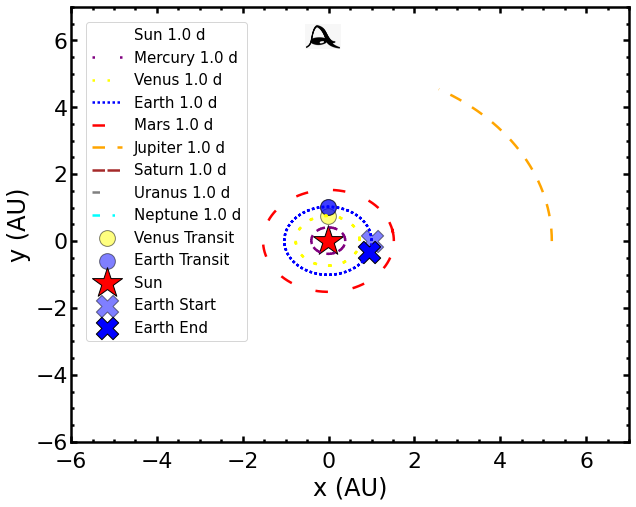

In [21]:
# Plot the orbits and the transits for the planets over the given number of earth orbits.
fig=plt.figure(figsize=(10,8))
transitss=[[0]]
for i, body in enumerate(b):
    x_au = [(xs/a[b["Earth"]]).value for xs in x[i]]
    y_au = [(ys/a[b["Earth"]]).value for ys in y[i]]
    z_au = [(zs/a[b["Earth"]]).value for zs in z[i]]
    line=next(linecycler)
    plt.plot(x_au,y_au,linestyle=line,color=colors[i],label=f'{list(b.items())[i][0]} {delta_t}')
    if i>0:
        SE_xdiff = abs(np.array([w.value for w in x[b["Sun"]]]) - np.array([w.value for w in x[i]]))
        transits=[]
        for o in range(orbits):
            orbit_steps=period[i]*steps/orbits
            xdiff = SE_xdiff[int(o*orbit_steps/2):int((o/2+1)*orbit_steps)]
            if len(SE_xdiff) > (int((o/2+1)*orbit_steps)+int(o*orbit_steps/2))/2:
                transits.append(np.where(min(xdiff)==SE_xdiff)[0][0])
        label_added=False
        if tuple(transits):
            for w in transits:
                if y[i][w] > 0:
                    if not label_added:
                        plt.scatter(x[i][w]/a_e,y[i][w]/a_e,marker="o",s=250,color=colors[i], edgecolors='black',label=f'{list(b.items())[i][0]} Transit',alpha=0.5)
                        label_added = True
                    else:
                        plt.scatter(x[i][w]/a[i],y[i][w]/a[i],marker="o",s=250,color=colors[i], edgecolors='black',alpha=0.5)
        transitss.append(transits)
plt.scatter(x[b["Sun"]][0]/a_e,y[b["Sun"]][0]/a_e,marker="*",s=1000,color='red', edgecolors='black',label=f'Sun')
plt.scatter(x[b["Earth"]][0]/a_e,y[b["Earth"]][0]/a_e,marker="X",s=500,color='blue', edgecolors='black',alpha=0.5,label=f'Earth Start')
# plt.scatter(x[b["Venus"]][0]/a_e,y[b["Venus"]][0]/a_e,marker="^",s=500,color='yellow', edgecolors='black',alpha=0.5,label=f'Venus Start')
plt.scatter(x[b["Earth"]][-1]/a_e,y[b["Earth"]][-1]/a_e,marker="X",s=500,color='blue', edgecolors='black',label=f'Earth End')
# plt.scatter(x[b["Venus"]][-1]/a_e,y[b["Venus"]][-1]/a_e,marker="^",s=500,color='yellow', edgecolors='black',label=f'Venus End')
plt.ylabel('y (AU)')
plt.xlabel('x (AU)')
plt.xlim(-6,7)
plt.ylim(-6,7)
plt.legend(prop={'size': 15})
new_img = ndimage.rotate(img, -90, reshape=True)
newax = fig.add_axes([0.45, 0.8, 0.05, 0.05], anchor='NE', zorder=1)
newax.imshow(new_img)
newax.axis('off')
plt.show()

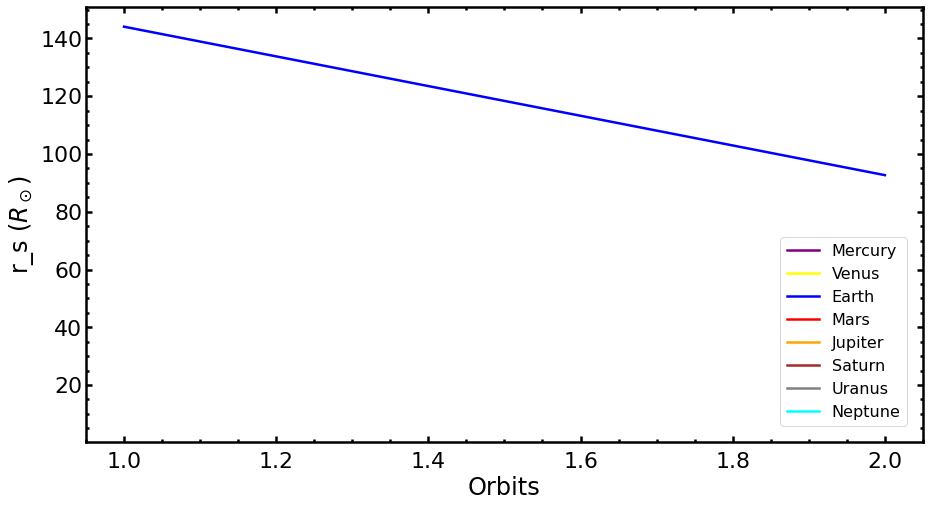

In [22]:
for i,t_array in enumerate(transitss):
    if i>0:
        r_s = [r_s_mag(r[b["Sun"]][t],r[i][t]).value/const.R_sun.value for t in t_array if y[i][t] > 0]
        time = range(1,len(r_s)+1)
        plt.plot(time,r_s,color=colors[i],label=f'{list(b.items())[i][0]}')
plt.ylabel(rf'r_s ($R_\odot$)')
plt.xlabel(f'Orbits')
plt.legend()
plt.show()

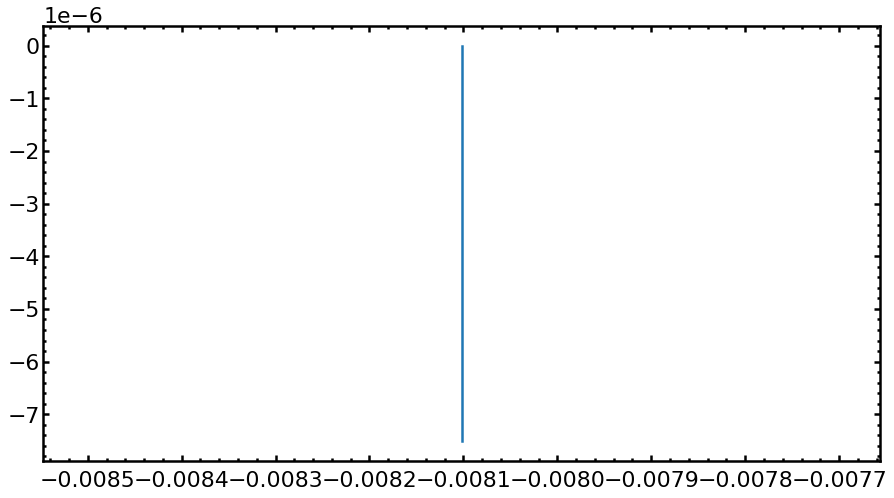

In [23]:
i=0
x_au = [(xs/a[b["Earth"]]).value for xs in x[i]]
y_au = [(ys/a[b["Earth"]]).value for ys in y[i]]
plt.plot(x_au[:int(len(x_au)/2)],y_au[0:int(len(x_au)/2)])
plt.plot(x_au[int(len(x_au)/2):],y_au[int(len(x_au)/2):])
plt.show()

In [24]:
r = [[(0,0,0)]*len(t_range)*u.cm for i in range(len(b))]
x = [[0]*len(t_range)*u.cm for i in range(len(b))]
y = [[0]*len(t_range)*u.cm for i in range(len(b))]
z = [[0]*len(t_range)*u.cm for i in range(len(b))]
v = [[(0,0,0)]*len(t_range)*u.cm/u.day for i in range(len(b))]
# dvdt2=[[(0,1,2)]*2 for i in range(3)]
# print(dvdt2)
# print(dvdt2[0][0])
dvdt=[0,0,0]
dvdt[0]=-(G * m_sun / r_ij**3 *(r[i][t+1][0]-r[j][t+1][0])).to(u.cm/u.day**2)
dvdt[1]=-(G * m_sun / r_ij**3 *(r[i][t+1][1]-r[j][t+1][1])).to(u.cm/u.day**2)
dvdt[2]=-(G * m_sun / r_ij**3 *(r[i][t+1][2]-r[j][t+1][2])).to(u.cm/u.day**2)
print(tuple(dvdt))
# dvdt2[0][0]=tuple(dvdt)
# print(dvdt2)

(<Quantity -0. cm / d2>, <Quantity -0. cm / d2>, <Quantity -0. cm / d2>)


In [25]:
def dvidt(M_j,r_ij,r_i,r_j):
    G = const.G.cgs
    dvdt=[0,0,0]
    dvdt[0] = -(G*M_j/r_ij**3*(r_i[0] - r_j[0])).to(u.cm/u.day**2)
    dvdt[1] = -(G*M_j/r_ij**3*(r_i[1] - r_j[1])).to(u.cm/u.day**2)
    dvdt[2] = -(G*M_j/r_ij**3*(r_i[2] - r_j[2])).to(u.cm/u.day**2)
    return dvdt

def rmag(r_i,r_j):
    x_i=r_i[0]
    y_i=r_i[1]
    z_i=r_i[2]
    x_j=r_j[0]
    y_j=r_j[1]
    z_j=r_j[2]
    r_ij = np.sqrt((x_i-x_j)**2+(y_i-y_j)**2+(z_i-z_j)**2)
    return r_ij

def r_s_mag(r_i,r_j):
    x_i=r_i[0]
    y_i=r_i[1]
    z_i=r_i[2]
    x_j=r_j[0]
    y_j=r_j[1]
    z_j=r_j[2]
    r_ij = np.sqrt((x_i-x_j)**2+(z_i-z_j)**2)
    return r_ij

In [26]:
linecycler = cycle([(0,()), # solid 
                     (0, (1, 10)), # loosely dotted
                     (0, (1, 5)), # dotted
                     (0, (1, 1)), # densely dotted
                     (0, (5, 10)), # loosely dashed
                     (0, (5, 5)), # dashed
                     (0, (5, 1)), # densely dashed
                     (0, (3, 10, 1, 10)), # loosely dashdotted
                     (0, (3, 5, 1, 5)), # dashdotted
                     (0, (3, 1, 1, 1)), # densely dashdotted
                     (0, (3, 10, 1, 10, 1, 10)), # loosely dashdotdotted
                     (0, (3, 5, 1, 5, 1, 5)), # dashdotdotted
                     (0, (3, 1, 1, 1, 1, 1))]) # densely dashdotdotted

b = OrderedDict((("Sun",0),("Mercury",1),("Venus",2),("Earth",3),("Mars",4),("Jupiter",5),("Saturn",6),("Uranus",7),("Neptune",8)))
b = OrderedDict((("Sun",0),("Venus",1),("Earth",2)))
b = OrderedDict((("Sun",0),("Mercury",1),("Venus",2),("Earth",3),("Mars",4),("Jupiter",5)))#,("Saturn",6),("Uranus",7),("Neptune",8)))

G = const.G.cgs
m_sun = const.M_sun.to(u.g)
m_hg = (0.330*10**27)*u.g
m_v = (4.8673*10**27)*u.g
m_e = const.M_earth.to(u.g)
m_m = (0.642*10**27)*u.g
m_j = (1898*10**27)*u.g
m_s = (568*10**27)*u.g
m_u = (14.5*10**27)*u.g
m_n = (17.1*10**27)*u.g
m = OrderedDict(((0,m_sun),(1,m_hg),(2,m_v),(3,m_e),(4,m_m),(5,m_j),(6,m_s),(7,m_u),(8,m_n)))
m = OrderedDict(((0,m_sun),(1,m_v),(2,m_e)))
m = OrderedDict(((0,m_sun),(1,m_hg),(2,m_v),(3,m_e),(4,m_m),(5,m_j)))#,(6,m_s),(7,m_u),(8,m_n)))

a_hg = 0.387*const.au.to(u.cm)
a_v = 0.723*const.au.to(u.cm)
a_e = const.au.to(u.cm)
a_m = 1.52*const.au.to(u.cm)
a_j = 5.20*const.au.to(u.cm)
a_s = 9.57*const.au.to(u.cm)
a_u = 19.17*const.au.to(u.cm)
a_n = 30.18*const.au.to(u.cm)
a = OrderedDict(((1,a_hg),(2,a_v),(3,a_e),(4,a_m),(5,a_j),(6,a_s),(7,a_u),(8,a_n)))
a = OrderedDict(((1,a_v),(2,a_e)))
a = OrderedDict(((1,a_hg),(2,a_v),(3,a_e),(4,a_m),(5,a_j)))#,(6,a_s),(7,a_u),(8,a_n)))
a_sun = -sum([m[i]*a[i] for i in a])/m_sun
a = OrderedDict(((0,a_sun),(1,a_hg),(2,a_v),(3,a_e),(4,a_m),(5,a_j),(6,a_s),(7,a_u),(8,a_n)))
a = OrderedDict(((0,a_sun),(1,a_v),(2,a_e)))
a = OrderedDict(((0,a_sun),(1,a_hg),(2,a_v),(3,a_e),(4,a_m),(5,a_j)))#,(6,a_s),(7,a_u),(8,a_n)))

v_sun = -(13*u.m/u.s).to(u.cm/u.day)
v_hg = 1.59*(29.78*u.km/u.s).to(u.cm/u.day)
v_v = 1.18*(29.78*u.km/u.s).to(u.cm/u.day)
v_e = (29.78*u.km/u.s).to(u.cm/u.day)
v_m = 0.808*(29.78*u.km/u.s).to(u.cm/u.day)
v_j = 0.439*(29.78*u.km/u.s).to(u.cm/u.day)
v_s = 0.325*(29.78*u.km/u.s).to(u.cm/u.day)
v_u = 0.228*(29.78*u.km/u.s).to(u.cm/u.day)
v_n = 0.182*(29.78*u.km/u.s).to(u.cm/u.day)
vstart = OrderedDict(((0,v_sun),(1,v_hg),(2,v_v),(3,v_e),(4,v_m),(5,v_j),(6,v_s),(7,v_u),(8,v_n)))
vstart = OrderedDict(((0,v_sun),(1,v_v),(2,v_e)))
vstart = OrderedDict(((0,v_sun),(1,v_hg),(2,v_v),(3,v_e),(4,v_m),(5,v_j)))#,(6,v_s),(7,v_u),(8,v_n)))

colors = OrderedDict(((0,'white'),(1,'purple'),(2,'yellow'),(3,'blue'),(4,'red'),(5,'orange'),(6,'brown'),(7,'gray'),(8,'cyan')))
period = OrderedDict(((0,0),(1,0.241),(2,0.615),(3,1),(4,1.88),(5,11.9),(6,29.4),(7,83.7),(8,163.7)))
colors = OrderedDict(((0,'white'),(1,'yellow'),(2,'blue')))
period = OrderedDict(((0,0),(1,0.615),(2,1)))
colors = OrderedDict(((0,'white'),(1,'purple'),(2,'yellow'),(3,'blue'),(4,'red'),(5,'orange')))#,(6,'brown'),(7,'gray'),(8,'cyan')))
period = OrderedDict(((0,0),(1,0.241),(2,0.615),(3,1),(4,1.88),(5,11.9)))#,(6,29.4),(7,83.7),(8,163.7)))

In [27]:
delta_t = 1*u.day

orbits = 50

t_range = np.arange(0,orbits*365,delta_t.value)*u.day      # 1 year timescale in steps of delta_t
# Initialize position and velocity arrays
r = [[[0,0,0]*u.cm for i in range(len(t_range))] for i in range(len(b))]
x = [[0]*len(t_range) for i in range(len(b))]
y = [[0]*len(t_range) for i in range(len(b))]
z = [[0]*len(t_range) for i in range(len(b))]
v = [[[0,0,0]*u.cm/u.day for i in range(len(t_range))] for i in range(len(b))]
dvdt = [[[0,0,0]*u.cm/u.day**2 for i in range(len(t_range))] for i in range(len(b))]

steps=len(t_range)                                  # The number of steps in the time array
# Set initial position for each body
for i,bdy in enumerate(b):
    r[i][0][0] = a[i]
    r[i][0][1] = 0*u.cm
    r[i][0][2] = 0*u.cm
    x[i][0] = r[i][0][0]
    y[i][0] = r[i][0][1]
    z[i][0] = r[i][0][2]
    v[i][0][0] = 0*u.cm/u.day
    v[i][0][1] = vstart[i]
    v[i][0][2] = 0*u.cm/u.day
    
for t in range(steps-1): # indexing each timestep as t
    # Update the next position for each body
    for i, body in enumerate(b):
        r[i][t+1][0] = r[i][t][0] + v[i][t][0]*delta_t
        r[i][t+1][1] = r[i][t][1] + v[i][t][1]*delta_t
        r[i][t+1][2] = r[i][t][2] + v[i][t][2]*delta_t

        x[i][t+1] = r[i][t+1][0]
        y[i][t+1] = r[i][t+1][1]
        z[i][t+1] = r[i][t+1][2]

    # Update the next velocity for each body
    for i, body in enumerate(b):
        # Sum effects of all bodies j on each body i in the system
        for j, body in enumerate(b):
            if i==j:
                continue
            r_ij = rmag(r[i][t+1],r[j][t+1])
            dvdt[i][t][0] += dvidt(m[j],r_ij,r[i][t+1],r[j][t+1])[0]
            dvdt[i][t][1] += dvidt(m[j],r_ij,r[i][t+1],r[j][t+1])[1]
            dvdt[i][t][2] += dvidt(m[j],r_ij,r[i][t+1],r[j][t+1])[2]

        v[i][t+1][0] = v[i][t][0] + dvdt[i][t][0] * delta_t
        v[i][t+1][1] = v[i][t][1] + dvdt[i][t][1] * delta_t
        v[i][t+1][2] = v[i][t][2] + dvdt[i][t][2] * delta_t 

In [1]:
# Plot the orbits and the transits for the planets over the given number of earth orbits.
plt.rcParams.update({"axes.facecolor":"gray"})
fig=plt.figure(figsize=(10,8))
transitss=[[0]]
for i, body in enumerate(b):
    x_au = [(xs/a[b["Earth"]]).value for xs in x[i]]
    y_au = [(ys/a[b["Earth"]]).value for ys in y[i]]
    z_au = [(zs/a[b["Earth"]]).value for zs in z[i]]
    line=next(linecycler)
    plt.plot(x_au,y_au,linestyle=line,color=colors[i],label=f'{list(b.items())[i][0]} {delta_t}')
    if i>0:
        SE_xdiff = abs(np.array([w.value for w in x[b["Sun"]]]) - np.array([w.value for w in x[i]]))
        transits=[]
        for o in range(int(orbits)+1):
            orbit_steps=period[i]*steps/orbits
            xdiff = SE_xdiff[int(o*orbit_steps/2):int((o/2+1)*orbit_steps)]
            if len(SE_xdiff) > (int((o/2+1)*orbit_steps)+int(o*orbit_steps/2))/2:
                transits.append(np.where(min(xdiff)==SE_xdiff)[0][0])
        label_added=False
        if tuple(transits):
            for w in transits:
                if y[i][w] > 0:
                    if not label_added:
                        plt.scatter(x[i][w]/a_e,y[i][w]/a_e,marker="o",s=250,color=colors[i], edgecolors='black',label=f'{list(b.items())[i][0]} Transit',alpha=0.5)
                        label_added = True
                    else:
                        plt.scatter(x[i][w]/a[i],y[i][w]/a[i],marker="o",s=250,color=colors[i], edgecolors='black',alpha=0.5)
        transitss.append(transits)
plt.scatter(x[b["Sun"]][0]/a_e,y[b["Sun"]][0]/a_e,marker="*",s=1000,color='red', edgecolors='black',label=f'Sun')
plt.scatter(x[b["Earth"]][0]/a_e,y[b["Earth"]][0]/a_e,marker="X",s=500,color='blue', edgecolors='black',alpha=0.5,label=f'Earth Start')
# plt.scatter(x[b["Venus"]][0]/a_e,y[b["Venus"]][0]/a_e,marker="^",s=500,color='yellow', edgecolors='black',alpha=0.5,label=f'Venus Start')
plt.scatter(x[b["Earth"]][-1]/a_e,y[b["Earth"]][-1]/a_e,marker="X",s=500,color='blue', edgecolors='black',label=f'Earth End')
# plt.scatter(x[b["Venus"]][-1]/a_e,y[b["Venus"]][-1]/a_e,marker="^",s=500,color='yellow', edgecolors='black',label=f'Venus End')
plt.ylabel('y (AU)')
plt.xlabel('x (AU)')
plt.xlim(-6,7)
plt.ylim(-6,7)
plt.legend(prop={'size': 15})
new_img = ndimage.rotate(img, -90, reshape=True)
newax = fig.add_axes([0.45, 0.8, 0.05, 0.05], anchor='NE', zorder=1)
newax.imshow(new_img)
newax.axis('off')
plt.show()

NameError: name 'plt' is not defined